# The Intricacy of Experimental Design and Estimating Truth

## Introduction

You are a scientist tasked with finding the formation cycle current profile that minimizes **capacity fading**. Equivalently, you could say you wish to maximize **cycle life** or maximize **battery stability**.

Recall that **formation** is a process that battery manufacturers perform on new lithium-ion batteries. During formation, manufacturers cycle the battery a few times in order to form a **solid-electrolyte interphase (SEI)** on the graphite particles in the anode. The specific chemical composition and physical structure of the SEI have a large impact on the stability of the battery. The composition and structure of the SEI are in turn affected by the specific charging and discharging **current profiles** used during formation.

Assume that the effects of different formation cycle current profiles can be summarized by the following two parameters:

- Current slope
- Current constant

The lecture notes explain the physical meanings of current slope and current constant. Note that real experiments performed in laboratories may vary three, four, five, or even more parameters. For simplicity's sake, we will consider just these two.

Your goal is to design an experiment to determine the values of current slope and current constant that minimize capacity fading. We will explore the following three approaches to experimental design:

- Grid search
- Random sampling
- Bayesian optimization

You know the following information:

- You can independently vary current slope and current constant. Both have an impact on capacity fading.
- Current slope and current constant can take any value between -3 and 3.
- You can perform a maximum of 20 measurements. Measurements are time-consuming and expensive, so you cannot do more.

## Tips and tricks

- Execute code cells by clicking the cell and hitting "Shift-Enter". You can also click the cell and then click the triangular play button in the taskbar.
- You can install the necessary dependencies by opening an Anaconda prompt shell in the Anaconda Navigator and running the following command:

```sh
conda env update --file "replace/with/path/to/environment.yml"
```

- Show the table of contents in the left sidebar by clicking on "View" in the taskbar and then selecting "Table of Contents".
- You may ask ChatGPT or similar for help if you have any difficulties.
- Ask a fellow student or the professor if you are unable to resolve an issue.

## Setup

Please run the code cell directly below to initialize the Jupyter Notebook. You may look at the code in the cell if you wish, but for this exercise is not necessary to understand what it does. After you've run the cell, navigate to the section titled "Experimental designs".

In [1]:
import random
import time
from typing import Iterable, Literal, Tuple

import IPython.display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


def show_parameter_space() -> None:
    (X, Y) = np.meshgrid(np.zeros(5), np.zeros(5))
    Z = Y
    
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.set_title("Parameter space")
    ax.grid()
    ax.set_xlabel("Current slope")
    ax.set_xlim(-3, 3)
    ax.set_ylabel("Current constant")
    ax.set_ylim(-3, 3)

    pcm = ax.pcolormesh(X, Y, Z, cmap="twilight")
    cbar = fig.colorbar(pcm)
    cbar.ax.set_ylabel("Capacity fading", rotation=-90, va="bottom")


def measure_capacity_fading(current_slope: float, current_constant: float) -> float:
    return (
        (current_slope**2 - 1) * (current_constant**2 - 5)
        + current_slope**2
        + current_constant**2
        - 6
    ) / ((current_slope - 0.1) ** 2 + current_constant**2 + 2) ** 2


ascii_scientist_1 = r"""
YOUR MEASUREMENT IS BEING PROCESSED. PLEASE WAIT!

                    _..._                  
                   //'''\\                 
                   ||. .||                 
                   |\ _ /|      (          
                  .-/\ /\-.     )   |      
                 |  ` \ '  |    _   |      
           (     | |  |  | |    H=--+-     
           ))    | |__|[ | |    U   |      
           __    \___(_3/ /     )   |      
-|_H_H_|---||---------|!|/------|---|---.  
 |_U_U_|  /__\        |_|      _[_ _|__  \ 
------------------------------------------`
"""

ascii_scientist_2 = r"""
YOUR MEASUREMENT IS BEING PROCESSED. PLEASE WAIT!

                    _..._                  
                   //'''\\                 
                   ||o o||                 
                   |\ _ /|      )          
                  .-/\ /\-.     (   |      
                 |  ` \ '  |    _   |      
           )     | |  |  | |    H=--+-     
           ((    | |__|[ | |    U   |      
           __    \___(_3/ /     (   |      
-|_H_H_|---||---------|!|/------|---|---.  
 |_U_U_|  /__\        |_|      _[_ _|__  \ 
------------------------------------------`
"""


def animate_scientist(num_frames: int=10) -> None:
    for _ in range(num_frames):
        IPython.display.clear_output(wait=True)
        print(ascii_scientist_1)
        time.sleep(0.5)

        IPython.display.clear_output(wait=True)
        print(ascii_scientist_2)
        time.sleep(0.5)


def lab_measurement(current_slope: float, current_constant: float) -> None:
    animate_scientist()
    IPython.display.clear_output
    print("YOUR MEASUREMENT IS FINISHED!")
    print(f"The measured capacity fading is: {measure_capacity_fading(current_slope, current_constant)}")


def linear(X: np.ndarray, a: float, b: float, c: float) -> float:
    return X[0] * a + X[1] * b + c


def quadratic(X: np.ndarray, a: float, b: float, c: float, d: float, e: float, f: float) -> float:
    return a * X[0] ** 2 + b * X[1] ** 2 + c * X[0] * X[1] + d * X[0] + e * X[1] + f


def gaussian(X: np.ndarray, A: float, mu_1: float, sigma_1: float, mu_2: float, sigma_2: float) -> float:
    exponent = -((X[0] - mu_1) ** 2 / (2 * sigma_1**2)) - (
        (X[1] - mu_2) ** 2 / (2 * sigma_2**2)
    )
    return A * np.exp(exponent)


def fit_function(
    model_function: Literal["linear", "quadratic", "gaussian"],
    measurements: pd.DataFrame,
) -> Tuple[np.ndarray, np.ndarray, pd.Series, pd.Series]:
    if model_function == "linear":
        f = linear
        popt = [1, 1, 1]
    elif model_function == "quadratic":
        f = quadratic
        popt = [1, 1, 1, 1, 1, 1]
    elif model_function == "gaussian":
        f = gaussian
        popt = [1, 1, 1, 1, 1]

    popt, pcov = curve_fit(f, [measurements.iloc[:, 0], measurements.iloc[:, 1]], measurements.iloc[:, 2], p0=popt)

    return popt, pcov, measurements.iloc[:, 0], measurements.iloc[:, 1]


def plot_gpr(
    gpr: GaussianProcessRegressor,
    current_slopes: Iterable[float],
    current_constants: Iterable[float],
    i: int,
    bounds: Iterable[int]=[-3, 3],
    minimize: bool=False
) -> None:
    resolution = 100
    x1_ = np.linspace(bounds[0], bounds[1], resolution)
    x2_ = x1_
    X1_, X2_ = np.meshgrid(x1_, x2_)
    X_all = [
        [X1_[i, j], X2_[i, j]] for i in range(resolution) for j in range(resolution)
    ]
    Y_all = gpr.predict(X_all, return_std=False)
    Y_all = Y_all.reshape((resolution, resolution))

    fig, ax = plt.subplots(figsize=(5, 5))
    
    pcm = ax.pcolormesh(X1_, X2_, Y_all, cmap="twilight")
    cbar = fig.colorbar(pcm)
    cbar.ax.set_ylabel("Capacity fading", rotation=-90, va="bottom")

    ax.set_title(f"Current knowledge after {i} measurements")
    ax.set_xlabel("Current slope")
    ax.set_ylabel("Current constant")
    ax.scatter(current_slopes, current_constants, marker="x", color="black")

    if minimize:
        y = gpr.predict(X_all)
        idx = np.where(y == min(y))[0][0]
        minx1 = X_all[idx][0]
        minx2 = X_all[idx][1]
        miny = min(y)
        ax.plot(minx1, minx2, "x", markersize=15, color="g")
        return minx1, minx2, miny


def bayesian_optimizer(measurements: pd.DataFrame, output: bool=True):
    print("YOUR DATA :")
    print(measurements)
    current_slope = measurements.iloc[:, 0]
    current_constant = measurements.iloc[:, 1]
    y = measurements.iloc[:, 2]

    kernel = RBF(length_scale=1)
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

    X = [[current_slope[i], current_constant[i]] for i in range(len(current_slope))]
    gpr.fit(X, y)
    if output:
        i = len(current_slope)
        plot_gpr(gpr, current_slope, current_constant, i)

        next_sample_1 = minimize(
            lambda x: upper_confidence_bound(x.reshape(1, -1), X, y, gpr, kappa=0.5),
            x0=np.random.uniform(0, 1, size=(2,)),
            bounds=[(-3, 3), (-3, 3)],
            method="L-BFGS-B",
        ).x

        next_sample_2 = minimize(
            lambda x: upper_confidence_bound(x.reshape(1, -1), X, y, gpr, kappa=1.5),
            x0=np.random.uniform(0, 1, size=(2,)),
            bounds=[(-3, 3), (-3, 3)],
            method="L-BFGS-B",
        ).x

        print(" YOUR NEXT MEASUREMENT POINTS SHOULD BE: ")
        print(" Measurement 1: ")
        print(f" Current slope : {next_sample_1[0]}")
        print(f" Current constant : {next_sample_1[1]}")
        print(" Measurement 2: ")
        print(f" Current slope : {next_sample_2[0]}")
        print(f" Current constant : {next_sample_2[1]}")
        print("RECORD THE CURRENT SLOPE AND CURRENT CONSTANT VALUES IN THE LAB BOOK.")
        print("THEN MEASURE THEM AND HIT SUBMIT")

    else:
        return gpr, current_slope, current_constant


def minimize_and_visualize(
    opt,
    cov,
    model_function: Literal["linear", "quadratic", "gaussian"],
    experimental_design: Literal["Random sampling", "Grid search", "Bayesian optimization"],
    original_current_slope=0,
    original_current_constant=0
):
    if model_function == "linear":
        f = linear
    elif model_function == "quadratic":
        f = quadratic
    elif model_function == "gaussian":
        f = gaussian

    x1 = np.linspace(-3, 3, 50)
    x2 = np.linspace(-3, 3, 50)
    X1, X2 = np.meshgrid(x1, x2)
    X1_all = X1.reshape(-1, 1)
    X2_all = X2.reshape(-1, 1)

    y = f([X1, X2], *opt)

    # minimize
    y_ = y.reshape(-1, 1)
    idx = np.where(y_ == min(y_))[0][0]
    minx1 = X1_all[idx]
    minx2 = X2_all[idx]
    miny = min(y_)

    # visualize
    fig, ax = plt.subplots(figsize=(5, 5))

    pcm = ax.pcolormesh(X1, X2, y, cmap="twilight")
    cbar = fig.colorbar(pcm)
    cbar.ax.set_ylabel("Capacity fading", rotation=-90, va="bottom")
    
    ax.set_title(f"{experimental_design} results")
    ax.set_xlabel("Current slope")
    ax.set_ylabel("Current constant")
    ax.plot(minx1, minx2, "x", markersize=15, color="g")
    ax.plot(original_current_slope, original_current_constant, "x", color="black")

    print("Your minimum can be found at: ")
    print(f"Current slope: {minx1}")
    print(f"Current constant: {minx2}")
    print(f"Capacity fading: {miny}")


def perform_random_sampling(measurements: pd.DataFrame, num_measurements: int):
    lower_bound = -3
    upper_bound = 3

    current_slopes = [random.uniform(lower_bound, upper_bound) for _ in range(num_measurements)]
    current_constants = [random.uniform(lower_bound, upper_bound) for _ in range(num_measurements)]
    capacity_fadings = [measure_capacity_fading(s, c) for (s, c) in zip(current_slopes, current_constants)]
    
    measurements.drop(measurements.index, inplace=True)
    for i in range(num_measurements):
        measurements.loc[len(measurements), measurements.columns] = [current_slopes[i], current_constants[i], capacity_fadings[i]]


# Acquisition function: Expected Improvement
def expected_improvement(X, X_sample, y_sample, gp, xi=0.01):
    X = X.reshape(-1, 2)  # Ensure correct shape for input points
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample = gp.predict(X_sample)

    # Calculate the improvement
    sigma = sigma.reshape(-1, 1)
    with np.errstate(divide="warn"):
        imp = mu - np.min(mu_sample) - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei


# Aquisition function: Upper confidence Bound
def upper_confidence_bound(X, X_sample, y_sample, gp, kappa=2.0):
    """
    Computes the Upper Confidence Bound (UCB) acquisition function for Bayesian Optimization.

    Parameters:
    X : np.ndarray
        Points where the UCB acquisition function should be evaluated, shape (n_points, n_features).
    X_sample : np.ndarray
        Sample locations already evaluated, shape (n_sample, n_features).
    y_sample : np.ndarray
        Sample values at X_sample, shape (n_sample,).
    gp : GaussianProcessRegressor
        A trained Gaussian Process model.
    kappa : float
        The exploration-exploitation trade-off parameter.

    Returns:
    np.ndarray
        UCB values for each point in X, shape (n_points,).
    """
    # Predict mean and standard deviation at each point X
    mu, sigma = gp.predict(X, return_std=True)
    # UCB calculation
    ucb = mu - kappa * abs(sigma)
    return ucb


def lab_notebook(measurements: pd.DataFrame) -> None:
    def create_input_row(initial_value: float=0.0) -> widgets.HBox:
        return widgets.HBox([widgets.FloatText(layout=widgets.Layout(width="150px")) for _ in measurements.columns])


    header = widgets.HBox([widgets.Label(value=column, layout=widgets.Layout(width="150px")) for column in measurements.columns])
    input_rows = widgets.VBox([
        widgets.HBox([
            widgets.FloatText(value=measurement["Current slope"], layout=widgets.Layout(width="150px")),
            widgets.FloatText(value=measurement["Current constant"], layout=widgets.Layout(width="150px")),
            widgets.FloatText(value=measurement["Capacity fading"], layout=widgets.Layout(width="250px")),
        ])
        for _, measurement in measurements.iterrows()
    ])

    add_measurement_button = widgets.Button(description="Add measurement")
    update_button = widgets.Button(description="Update", button_style="success")
    
    
    def on_add_measurement(unused_add_measurement_button: widgets.Button) -> None:
        input_rows.children = list(input_rows.children) + [create_input_row()]
    
    
    def on_update(update_button: widgets.Button) -> None:
        measurements.drop(measurements.index, inplace=True)
        for input_row in input_rows.children:
            measurements.loc[len(measurements), measurements.columns] = [cell.value for cell in input_row.children]


    add_measurement_button.on_click(on_add_measurement)
    update_button.on_click(on_update)
    IPython.display.display(header, input_rows, widgets.HBox([add_measurement_button, update_button]))


columns = ["Current slope", "Current constant", "Capacity fading"]
grid_search_measurements = pd.DataFrame(columns=columns)
random_sampling_measurements = pd.DataFrame(columns=columns)
bayesian_optimization_measurements = pd.DataFrame(columns=columns)

## Experimental designs

We will explore the following three approaches to experimental design:

- Grid search
- Random sampling
- Bayesian optimization

Your goal is to determine the values of current slope and current constant that minimize the measured capacity fading. Run the next code cell to see a visualization of the parameter space.

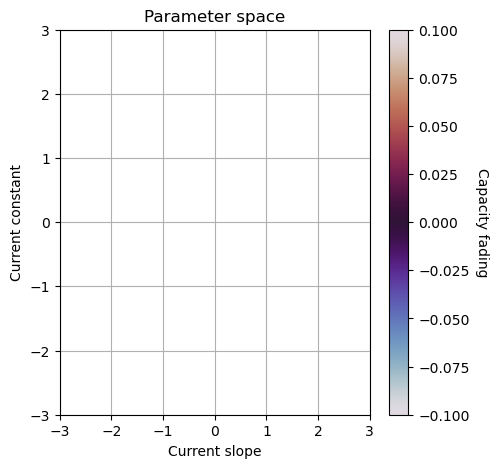

In [2]:
show_parameter_space()

### Grid search

A simple approach to optimizing multiple parameters is to systematically explore the entire parameter space. For example, you might test the following parameter values:

| Current slope | Current constant |
| ------------- | ---------------- |
| -3            | -3               |
| -3            | 0                |
| -3            | 3                |
| 0             | -3               |
| 0             | 0                |
| 0             | 3                |
| 3             | -3               |
| 3             | 0                |
| 3             | 3                |

Think about how you will approach the experiment.

- What parameter values will you measure?
- How will you know when you've found the optimal values for current slope and current constant?

Perform your experiment with the `lab_measurement` method below by giving it values for the current slope and current constant. Then record your measurements in the lab notebook. Remember to click "Update" after entering your measurements.

In [12]:
lab_measurement(current_slope=3, current_constant=3)


YOUR MEASUREMENT IS BEING PROCESSED. PLEASE WAIT!

                    _..._                  
                   //'''\\                 
                   ||o o||                 
                   |\ _ /|      )          
                  .-/\ /\-.     (   |      
                 |  ` \ '  |    _   |      
           )     | |  |  | |    H=--+-     
           ((    | |__|[ | |    U   |      
           __    \___(_3/ /     (   |      
-|_H_H_|---||---------|!|/------|---|---.  
 |_U_U_|  /__\        |_|      _[_ _|__  \ 
------------------------------------------`

YOUR MEASUREMENT IS FINISHED!
The measured capacity fading is: 0.11678891014977912


In [4]:
lab_notebook(grid_search_measurements)

VBox()

In [14]:
grid_search_measurements

,Current slope,Current constant,Capacity fading
0,-3.0,-3.0,0.103585
1,-3.0,0.0,-0.274497
2,-3.0,3.0,0.103585
3,0.0,-3.0,-0.008249
4,0.0,0.0,-0.247519
5,0.0,3.0,-0.008249
6,3.0,-3.0,0.116789
7,3.0,0.0,-0.341429
8,3.0,3.0,0.116789


Once you have conducted all of the measurements, try to determine the optimal values for current slope and current constant by looking at your data. Which parameter values minimize the capacity fading?

Next, try to determine the minimium by modeling your data with different functions. Run the following code cell. Try choosing different values for `model_function`. How does your choice impact the estimated minimium?

/tmp/nix-shell-97139-0/ipykernel_134955/76698282.py:125: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f, [measurements.iloc[:, 0], measurements.iloc[:, 1]], measurements.iloc[:, 2], p0=popt)


Your minimum can be found at: 
Current slope: [0.18367347]
Current constant: [-0.06122449]
Capacity fading: [-0.32706486]


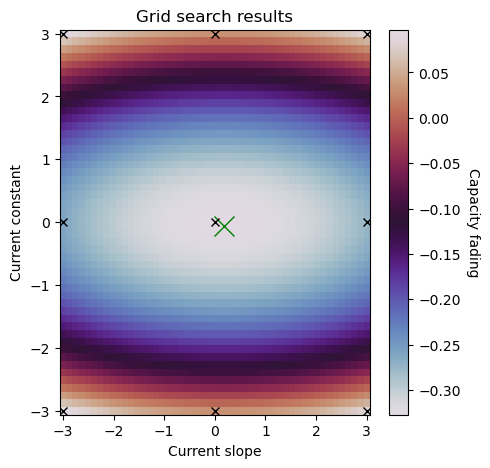

In [15]:
# model_function can be set to "quadratic", "linear", or "gaussian"
model_function = "quadratic"
opt, cov, current_slope, current_constant = fit_function(model_function, grid_search_measurements)
minimize_and_visualize(
    opt,
    cov,
    model_function,
    experimental_design="Grid search",
    original_current_slope=current_slope,
    original_current_constant=current_constant
)

Compare your own minimum and to that found by the function fit.

- How much do they differ?
- Is there a way to determine which one is more accurate?
- What are the benefits of this approach to experimental design?
- What are the drawbacks of this approach to experimental design?

### Random sampling

Random sampling is the process of repeatedly selecting parameter values to measure at random. Common choices for sampling distributions are the uniform and normal (Gaussian) distributions. Since you are already an expert in the lab, you now have a student assistant who will do all the measurements for you. All you need to do is execute the next cell.

In [16]:
perform_random_sampling(random_sampling_measurements, num_measurements=20)

In [17]:
random_sampling_measurements

,Current slope,Current constant,Capacity fading
0,0.785841,2.431465,0.002573
1,2.73379,-0.345846,-0.365773
2,-1.869279,0.631941,-0.344654
3,-1.183731,-0.083575,-0.493694
4,-2.03462,0.210585,-0.398764
5,-0.347012,-1.026526,-0.127981
6,0.142766,1.037378,-0.111843
7,1.825877,-2.512561,0.052635
8,-2.777088,1.16421,-0.158105
9,1.941262,2.966596,0.08487


- As before, try to determine the minimum by hand.
- As before, try to determine the minimum by modeling your data with different functions.

Your minimum can be found at: 
Current slope: [-3.]
Current constant: [-0.42857143]
Capacity fading: [-0.41330422]


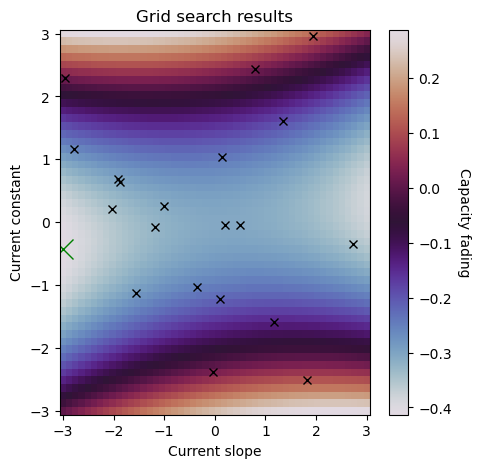

In [18]:
# model_function can be set to "quadratic", "linear", or "gaussian"
model_function = "quadratic"
opt, cov, current_slope, current_constant = fit_function(model_function, random_sampling_measurements)
minimize_and_visualize(
    opt,
    cov,
    model_function,
    experimental_design="Grid search",
    original_current_slope=current_slope,
    original_current_constant=current_constant
)

- How accurate is the minimum this time?
- What are some drawbacks of this approach to experimental design?

### Bayesian optimization

A Bayesian Optimizer is an algorithm that continuously updates its knowledge about the measured system. You start by 'feeding' the algorithm 4 initial datapoints. After that, the algorithm tells you where to measure next to try and find the optimal parameter values.

Determine the four initial datapoints by running the next cell.

In [19]:
perform_random_sampling(bayesian_optimization_measurements, num_measurements=4)

Next, run the Bayesian optimizer. It will tell you the next two measurement points and display its current state of knowledge about the system in a graph. Note down your next parameter_values points in the LabBook, perform the measurement as before, and write down the result likewise. Repeat this until you have performed all of your 20 experiments.

In [25]:
lab_measurement(current_slope=-3, current_constant=3)


YOUR MEASUREMENT IS BEING PROCESSED. PLEASE WAIT!

                    _..._                  
                   //'''\\                 
                   ||o o||                 
                   |\ _ /|      )          
                  .-/\ /\-.     (   |      
                 |  ` \ '  |    _   |      
           )     | |  |  | |    H=--+-     
           ((    | |__|[ | |    U   |      
           __    \___(_3/ /     (   |      
-|_H_H_|---||---------|!|/------|---|---.  
 |_U_U_|  /__\        |_|      _[_ _|__  \ 
------------------------------------------`

YOUR MEASUREMENT IS FINISHED!
The measured capacity fading is: 0.10358495767495088


In [20]:
lab_notebook(bayesian_optimization_measurements)

YOUR DATA :
  Current slope Current constant Capacity fading
0      1.195488        -1.834552       -0.044231
1     -1.131083         1.224328       -0.167014
2      0.939204          2.28316        0.001114
3     -2.539856         0.606661       -0.280226
4          -3.0             -3.0        0.103585
5          -3.0              3.0        0.103585
 YOUR NEXT MEASUREMENT POINTS SHOULD BE: 
 Measurement 1: 
 Current slope : -3.0
 Current constant : -0.07328173773648984
 Measurement 2: 
 Current slope : 3.0
 Current constant : 0.1480526596110777
RECORD THE CURRENT SLOPE AND CURRENT CONSTANT VALUES IN THE LAB BOOK.
THEN MEASURE THEM AND HIT SUBMIT


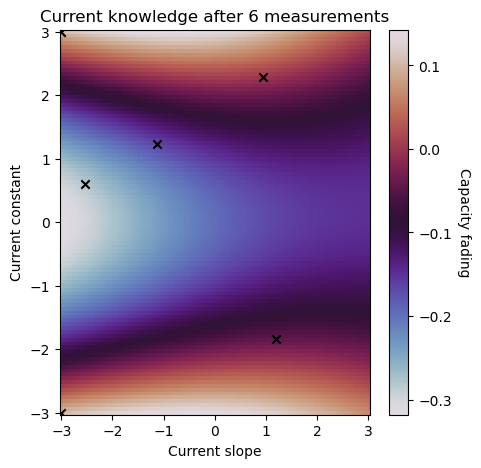

In [26]:
bayesian_optimizer(bayesian_optimization_measurements)

## Conclusion

- Compare all of your results. Which approach to experimental design finds the minimum capacity fading?
- How far apart are the results?
- Write down the advantages and disadvantages of all three experimental designs, including how the choice of modeling function influences the final result.